In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from adjustText import adjust_text  

# Load dataset
df = pd.read_csv("team_stats_advanced_rs.csv")


In [28]:
# Filter to only 2020-21, 2021-22, 2022-23 seasons
valid_seasons = ["2020-21", "2021-22", "2022-23"]
df = df[df["SEASON"].isin(valid_seasons)].reset_index(drop=True)

print("Number of rows after filtering:", len(df))
print(df["SEASON"].value_counts())

# Clustering
features = [
    "OFF_RATING",
    "DEF_RATING",
    "PACE",
    "EFG_PCT",
    "TM_TOV_PCT",
    "OREB_PCT",
    "DREB_PCT"
]

X = df[features].dropna()

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Number of rows after filtering: 90
SEASON
2020-21    30
2021-22    30
2022-23    30
Name: count, dtype: int64


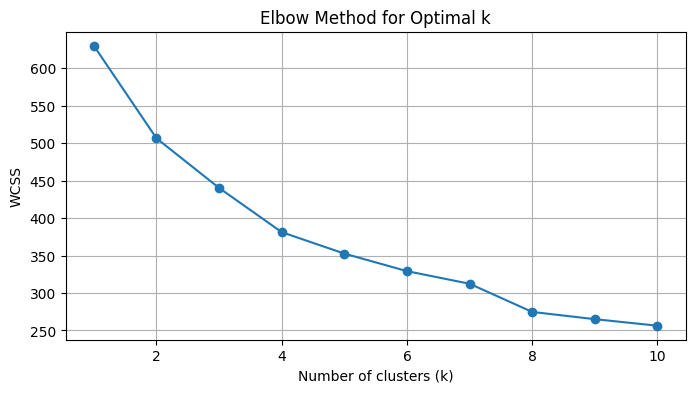

In [29]:
# Elbow Method
wcss = []

for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

# 6. KMeans
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df["cluster"] = labels


Cluster Centroids:
         OFF_RATING  DEF_RATING        PACE   EFG_PCT  TM_TOV_PCT  OREB_PCT  \
cluster                                                                       
0        113.922727  113.772727  100.975455  0.549227    0.138500  0.266091   
1        112.840000  111.256000   98.057600  0.531760    0.130800  0.278480   
2        114.220833  110.458333   99.046667  0.552917    0.140875  0.272500   
3        107.715789  114.652632   99.940000  0.516158    0.147263  0.274474   

         DREB_PCT  
cluster            
0        0.712500  
1        0.727280  
2        0.742042  
3        0.722526  


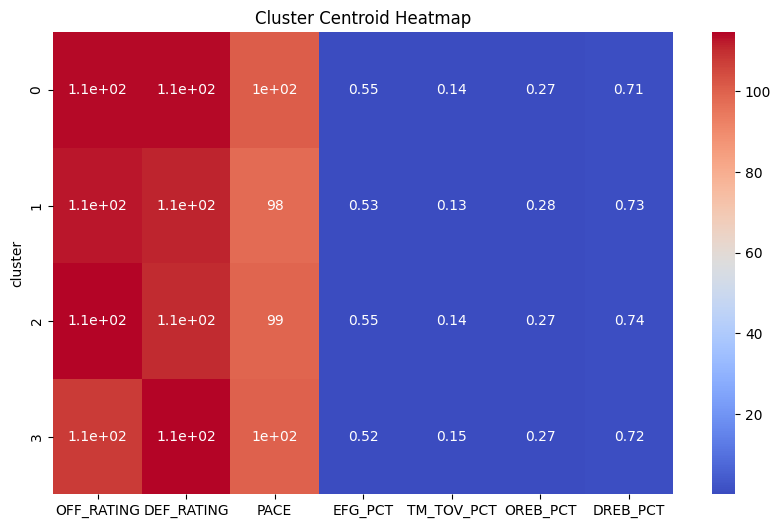


Saved clustered dataset as: team_clusters_2021_2023.csv


In [30]:
centroids = df.groupby("cluster")[features].mean()
print("\nCluster Centroids:")
print(centroids)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(centroids, annot=True, cmap="coolwarm")
plt.title("Cluster Centroid Heatmap")
plt.show()

# Clustered Dataset
df.to_csv("team_clusters_2021_2023.csv", index=False)
print("\nSaved clustered dataset as: team_clusters_2021_2023.csv")

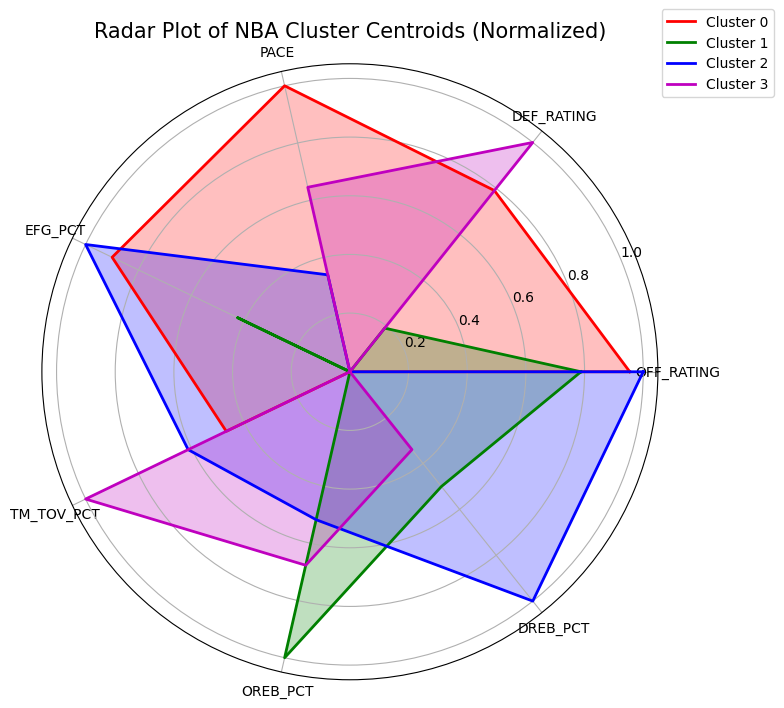

In [31]:
#Radar Plot

features = ["OFF_RATING","DEF_RATING","PACE","EFG_PCT","TM_TOV_PCT","OREB_PCT","DREB_PCT"]

scaler = MinMaxScaler()
centroids_normalized = scaler.fit_transform(centroids[features])
centroids_normalized = pd.DataFrame(centroids_normalized, columns=features, index=centroids.index)

num_vars = len(features)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

colors = ['r', 'g', 'b', 'm']

for i, cluster_id in enumerate(centroids_normalized.index):
    values = centroids_normalized.loc[cluster_id].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, color=colors[i], linewidth=2, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, color=colors[i], alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)

plt.title("Radar Plot of NBA Cluster Centroids (Normalized)", size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


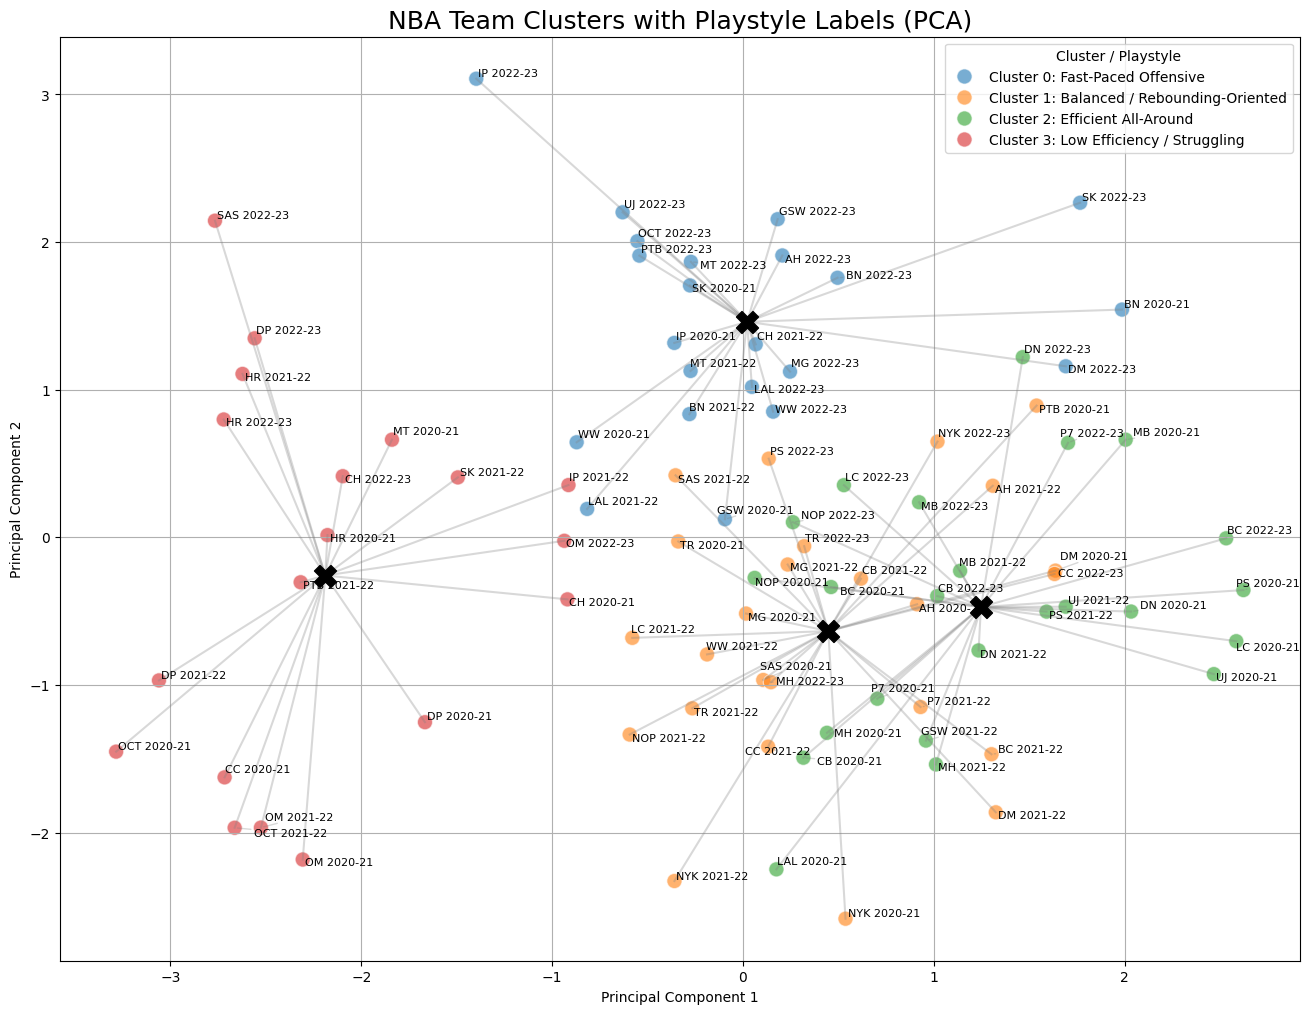

In [32]:
#Cluster Graph

features = ["OFF_RATING","DEF_RATING","PACE","EFG_PCT","TM_TOV_PCT","OREB_PCT","DREB_PCT"]

X_scaled = StandardScaler().fit_transform(df[features])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]

cluster_labels = {
    0: "Fast-Paced Offensive",
    1: "Balanced / Rebounding-Oriented",
    2: "Efficient All-Around",
    3: "Low Efficiency / Struggling"
}

df['TEAM_ACRONYM'] = df['TEAM_NAME'].apply(lambda x: ''.join([word[0] for word in x.split()]).upper())
df['LABEL'] = df['TEAM_ACRONYM'] + ' ' + df['SEASON']

cluster_order = [0, 1, 2, 3]
df['CLUSTER_LABEL'] = pd.Categorical(
    df['cluster'].map(lambda x: f"Cluster {x}: {cluster_labels[x]}"),
    categories=[f"Cluster {i}: {cluster_labels[i]}" for i in cluster_order],
    ordered=True
)

centroids_pca = df.groupby('cluster')[['PCA1','PCA2']].mean()

plt.figure(figsize=(16,12))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='CLUSTER_LABEL', palette='tab10', s=120, alpha=0.6)

plt.scatter(centroids_pca['PCA1'], centroids_pca['PCA2'], color='black', s=250, marker='X', zorder=5)

for i, row in df.iterrows():
    centroid = centroids_pca.loc[row['cluster']]
    plt.plot([row['PCA1'], centroid['PCA1']], [row['PCA2'], centroid['PCA2']], color='gray', alpha=0.3)

texts = []
for i, row in df.iterrows():
    texts.append(plt.text(row['PCA1'], row['PCA2'], row['LABEL'], fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.3))

plt.title('NBA Team Clusters with Playstyle Labels (PCA)', size=18)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster / Playstyle', loc='upper right')
plt.grid(True)
plt.show()
